<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Applied Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Lab: CAN Response</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Aiman
* Tomy Gunawan
* Angel Ling
---

based on *GEOS 626: Applied Seismology from Carl Tape*

---

### CAN response

This script shows some conventions for instrument response files associated with GISMO/Antelope and rdseed/sac.
 
calls numerous GISMO functions and also read_pzfile.m

The example waveform is from CAN (Canberra, Australia) for the 2004 Mw 9.X Sumatra-Andaman earthquake.

In [63]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import xcorr_pick_correction
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import wave
import struct
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['lines.linewidth'] = 1

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-25T12:58:53.655900Z - 2005-01-04T00:58:51.655900Z | 1.0 Hz, 820799 samples


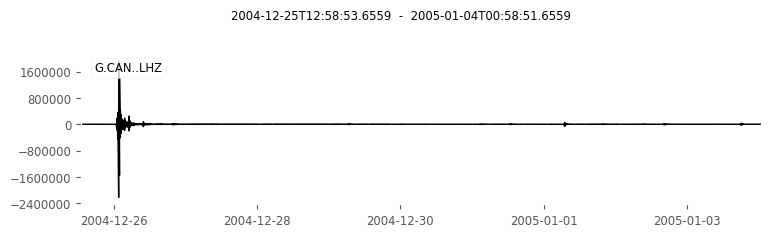

In [64]:
# Getting the waveforms

client = Client("IRIS")
t = UTCDateTime("2004-12-26T00:58:53.0")
starttime = t-(12*3600) # half day before the earthquake
endtime = t+(9*24*3600) # 9 days after the earthquake

st = client.get_waveforms("G", "CAN", "*", "LHZ", starttime, endtime, attach_response=True)
print(st)

st.plot()

(-30000, 30000)

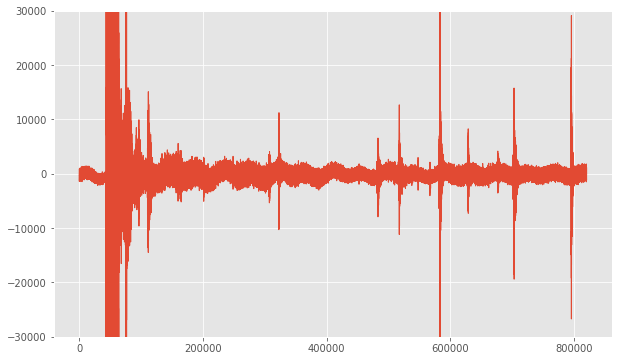

In [65]:
# Plotting signals
tr = st[0]
trace_data = tr.data
plt.plot(tr.data)
plt.ylim(-30000,30000)

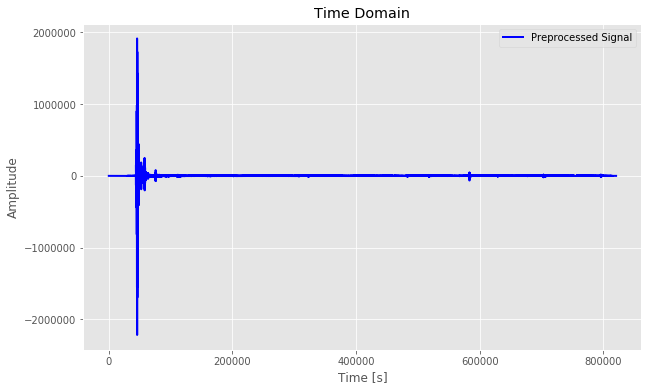

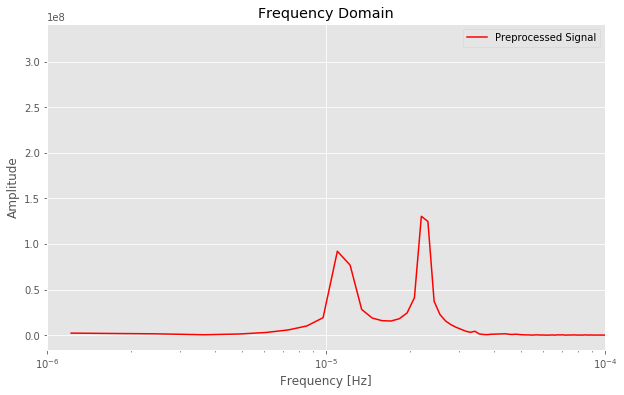

In [66]:
#Pre-Process Data 
from obspy.signal.filter import lowpass
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper 

# take a copy of the stream to avoid overwriting the original data
can = st.copy()

# Choosing the 1st stream, Specify sampling parameters and Nyquist frequency
npts = can[0].stats.npts              # number of samples
df = can[0].stats.sampling_rate       # sampling rate
nsec = npts/df                        # sampling time
fNy = df / 2.0                        # Nyquist frequency
time = np.linspace(0,nsec,(nsec*df))  # time axis for plotting

y  = can[0].data                      # set up signal   

# Taper
taper_percentage = 0.1                          # Percentage of tapering applied to signal
taper = cosine_taper(npts,taper_percentage)    # Define cosine taper to be used
y_taper = y * taper                         # Taper signal

# Detrend Signal
y_detrend = detrend(y_taper, 'linear')

# Frequency Domain
y_fnew = np.fft.rfft(y_detrend) 

# Plot the result
# Plot in Time Domain
freq = np.linspace(0, fNy, len(y_fnew))         # Frequency axis for plotting
plt.plot(time, y_detrend, 'b', label="Preprocessed Signal", lw=2) 
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Plot in Frequency Domain (Frequency Spectrum)
plt.semilogx(freq, abs(y_fnew), 'r', label="Preprocessed Signal", lw=1.5) 
plt.legend()
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(1E-6, 1E-4) # limited to lower frquencies
plt.show()

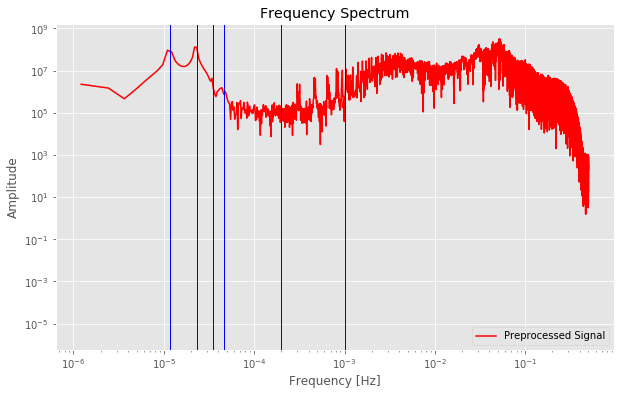

In [67]:
# Set up frequency windows
f0 = 1/(24*3600)
k1 = 1*f0
k2 = 2*f0
k3 = 3*f0
k4 = 4*f0

# Set up [0.2, 1.0] mHz window
k5 = 1E-3
k6 = 2E-4

# Plot frequency domain in log-log scale
plt.semilogx(freq, abs(y_fnew), 'r', label="Preprocessed Signal", lw=1.5) 
plt.axvline(k1, color ='b')
plt.axvline(k2, color ='b')
plt.axvline(k3, color ='b')
plt.axvline(k4, color ='b')
plt.axvline(k5, color ='b')
plt.axvline(k6, color ='b')
plt.legend()
plt.title('Frequency Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.show()

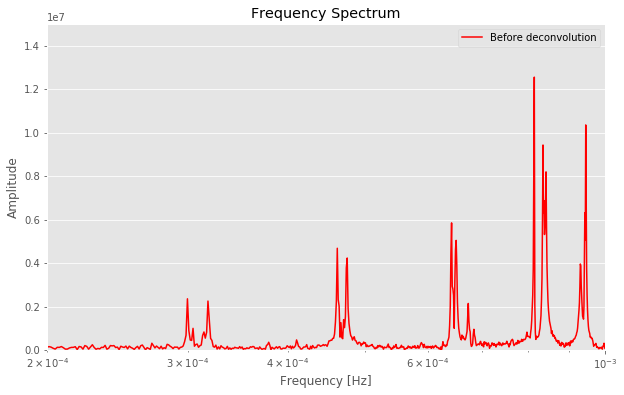

In [68]:
# Plot Frequency spectrum in [0.2, 1] mHz window
plt.semilogx(freq, abs(y_fnew), 'r', label="Before deconvolution", lw=1.5) 
plt.legend()
plt.title('Frequency Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(2E-4, 1E-3) # limited to frequency window
plt.ylim(0.0, 1.5E7) # Zoom in 
plt.show()

Inventory created at 2017-12-13T10:35:11.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?level=response&start...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			G
		Stations (1):
			G.CAN (Canberra, Australia)
		Channels (1):
			G.CAN..LHZ


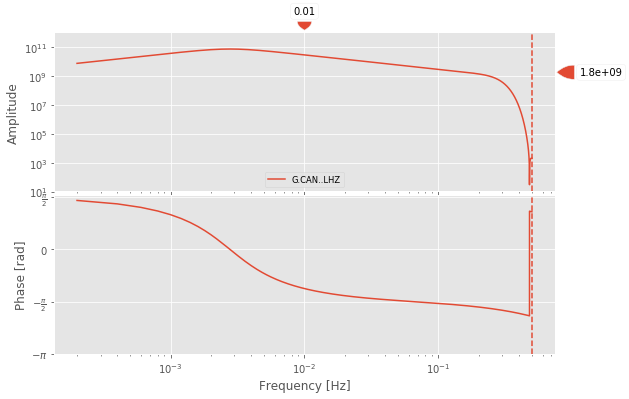

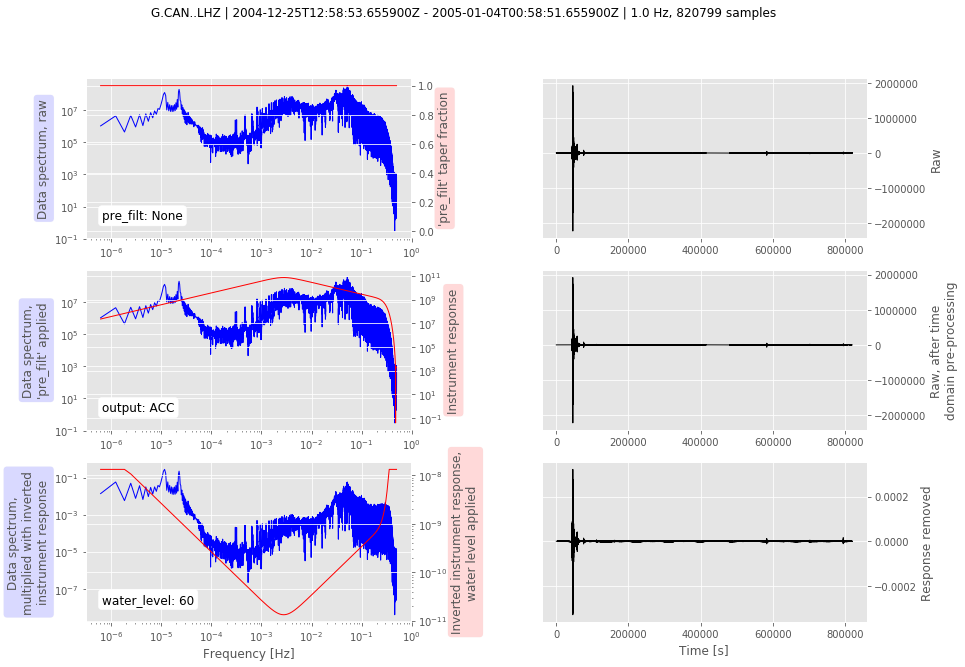

In [69]:
# Plot station response
inv = client.get_stations(network="G", station="CAN", channel="LHZ", level="response", 
                     starttime=starttime, endtime=endtime)
print(inv)

inv.plot_response(min_freq=2E-4, output='ACC')

tr_new = st.select(component="Z").copy().remove_response(
    inventory=inv, output="ACC", plot=True)[0]

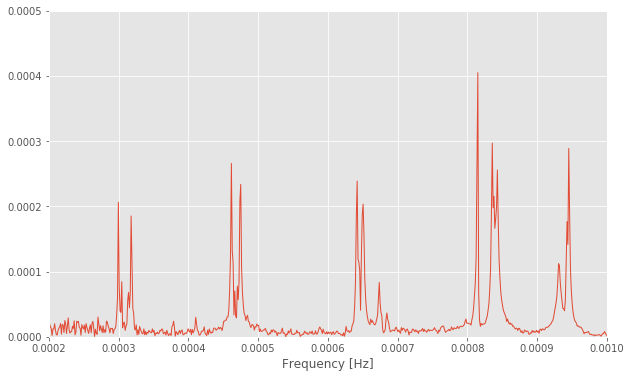

In [76]:
# Deconvolution
# Remember to copy the waveform!

tr_de = st.select(component="Z").copy().remove_response(inventory=inv, output="ACC")[0].taper(0.05)

D = np.fft.rfft(tr_de.data)
freqs = np.fft.rfftfreq(tr_de.stats.npts, d=tr_de.stats.delta)

# Alternatively using scipy.fftpack
#from scipy.fftpack import fft, rfft
#from scipy.fftpack import fftfreq, rfftfreq

#D = rfft(tr_de.data)
#freqs = rfftfreq(tr_de.stats.npts, tr_de.stats.delta)

plt.plot(freqs, np.abs(D))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0.0, 5.0E-4)
plt.xlabel("Frequency [Hz]")
plt.show()

# Alternatively
#tr_de = st.select(component="Z")[0].copy().taper(0.05)

#D = np.fft.rfft(tr_de.data)
#freqs = np.fft.rfftfreq(tr_de.stats.npts, d=tr_de.stats.delta)
#freq_response, _ = \
#    inv.select(channel="LHZ")[0][0][0].response.get_evalresp_response(
#        tr_de.stats.delta, tr_de.stats.npts, output="ACC")

#plt.plot(freqs, np.abs(D)/ np.abs(freq_response))
#plt.xlim(0.2E-3, 1.0E-3)
#plt.ylim(0.0,5.0E-4)
#plt.xlabel("Frequency [Hz]")
#plt.show()

In [71]:
#st[0].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   #plot=False)
#st[1].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   #plot=False)
#st[2].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   #plot=True)